In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

TRAINDIR = 'faces/train' # directory where we store our data
IMG_Y_SIZE = 112
IMG_X_SIZE = 92
NUM_NAMES = 40
names = os.listdir(TRAINDIR) # list of classes i.e. names


def show_img(im):  # Display the image only
    plt.figure(figsize=(3, 3))  # Smaller figure
    plt.imshow(im, cmap='gray')
    plt.axis('off')  # Hide axes for cleaner look
    plt.tight_layout()
    plt.show()

def show_img_label(im, label):  # Display image with title as label
    plt.figure(figsize=(3, 3))
    plt.imshow(im, cmap='gray')
    plt.title(label, fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# check out VGG or '
# 1. input face image and get a vector representation (features)
# GAN model inversion

In [2]:
# load the training data


training_data = []

def create_training_data():
    for name in names:
        name_num = names.index(name)
        for img in os.listdir(f"{TRAINDIR}/{name}"):
            img_array = cv2.imread(f"{TRAINDIR}/{name}/{img}",cv2.IMREAD_GRAYSCALE) # convert the image to its pixel (brightness value) data
            new_array = cv2.resize(img_array,(IMG_X_SIZE,IMG_Y_SIZE)) # resize if need be
            training_data.append([new_array, name_num]) # add it to training_data along with its name

create_training_data()

random.shuffle(training_data) # randomize the training data (make learning more effective)
    

In [3]:
# prepare the training data for ML i.e. convert to numpy

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1,IMG_X_SIZE,IMG_Y_SIZE,1)
y = np.array(y)

print(X.shape, y.shape)

(360, 92, 112, 1) (360,)


In [4]:
import pickle

# save your data (so you don't have to load it every time)

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [5]:
TESTDIR = 'faces/test' # directory where we store our testing data

# load the testing data


testing_data = []

def create_testing_data():
    for name in names:
        name_num = names.index(name)
        for img in os.listdir(f"{TESTDIR}/{name}"):
            img_array = cv2.imread(f"{TESTDIR}/{name}/{img}",cv2.IMREAD_GRAYSCALE) # convert the image to its pixel (brightness value) data
            new_array = cv2.resize(img_array,(IMG_X_SIZE,IMG_Y_SIZE)) # resize if need be
            testing_data.append([new_array, name_num]) # add it to testing_data along with its name

create_testing_data()


In [6]:
XT = []
yt = []

for features, label in testing_data:
    XT.append(features)
    yt.append(label)
    

XT = np.array(XT).reshape(-1,IMG_X_SIZE,IMG_Y_SIZE,1)
yt = np.array(yt)
print(XT.shape, yt.shape)

(40, 92, 112, 1) (40,)


In [7]:
# save your data (so you don't have to load it every time)

pickle_out = open("XT.pickle","wb")
pickle.dump(XT, pickle_out)
pickle_out.close()


pickle_out = open("yt.pickle","wb")
pickle.dump(yt, pickle_out)
pickle_out.close()



In [8]:
import tensorflow as tf
#GPU test and settings
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)
#gpu_optoins = tf.GPUOptions(per_process_gpu_memory_fraction=0.3333)
#sess=tf.Session(config=tf.ConfigProto(gpu_options=gpuoptions))

Num GPUs Available:  0


In [9]:
import pickle
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle","rb"))
XT = pickle.load(open("XT.pickle", "rb"))
yt = pickle.load(open("yt.pickle","rb"))
X = X/255.0
XT = XT/255.0

train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(10000).batch(10)

test_ds = tf.data.Dataset.from_tensor_slices((XT, yt)).batch(10)


print(train_ds.cardinality().numpy(), test_ds.cardinality().numpy())

36 4


In [10]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle

# tensorflow is the most popular supported framework by all MLaaS service providers

X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle","rb"))
X = X/255.0

print(X.shape,y.shape)

NAME = "Face-Recognition-CNN-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

model= Sequential([
    Input((IMG_X_SIZE,IMG_Y_SIZE, 1)),
    Conv2D(filters=36, kernel_size=7, activation='relu'),
    Flatten(),
    Dense(NUM_NAMES, activation='softmax')  
])

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])




(360, 92, 112, 1) (360,)


In [11]:
# get a summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 86, 106, 36)    │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 328176)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │    13,127,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,128,880 (50.08 MB)

 Trainable params: 13,128,880 (50.08 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# train the model
model.fit(X, y, batch_size=40,epochs=20, callbacks = [tensorboard])

# to view tensorboard, go to terminal, cd to sarahs-inversion and type
# tensorboard --logdir='logs/'

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.0246 - loss: 13.7769
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.4070 - loss: 2.4826
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9175 - loss: 0.5422
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.9830 - loss: 0.1172
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 1.0000 - loss: 0.0183
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 1.0000 - loss: 0.0055
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 1.0000 - loss: 6.1104e-04
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 1.0000 - loss: 5.4779e-04
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 1.0000 - loss: 4.6620e-04
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy

Decoding:  s1


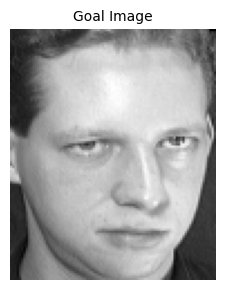

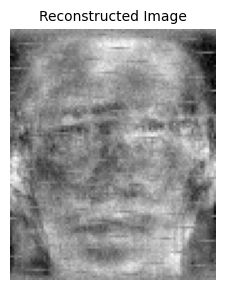

Decoding:  s10


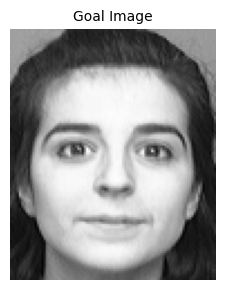

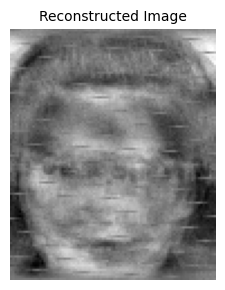

Decoding:  s11


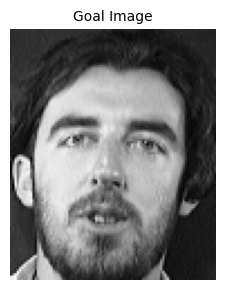

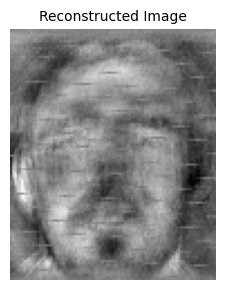

Decoding:  s12


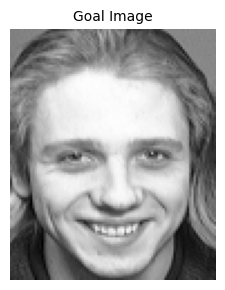

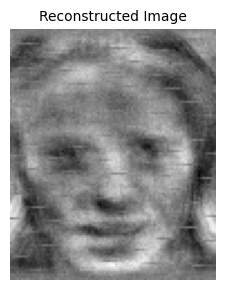

Decoding:  s13


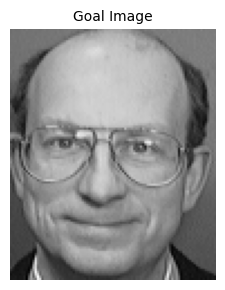

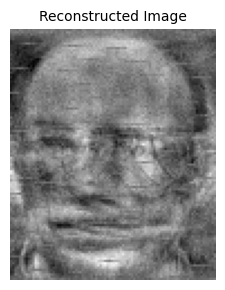

Decoding:  s14


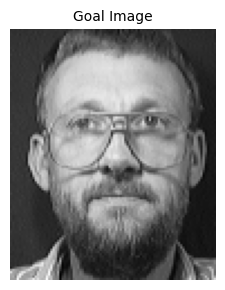

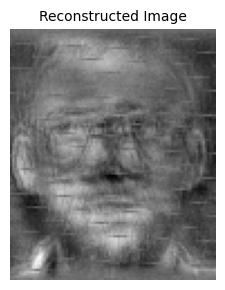

Decoding:  s15


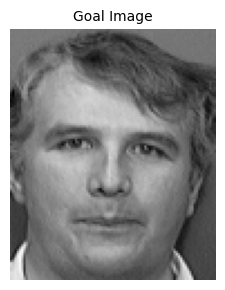

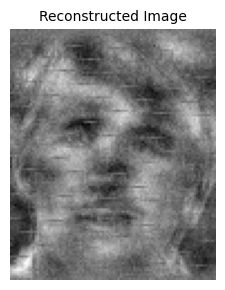

Decoding:  s16


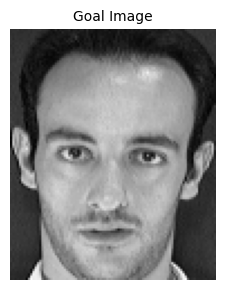

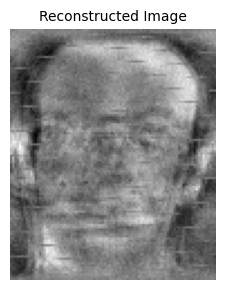

Decoding:  s17


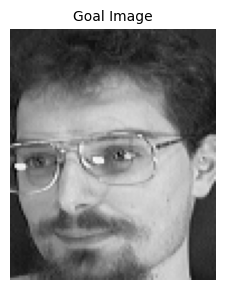

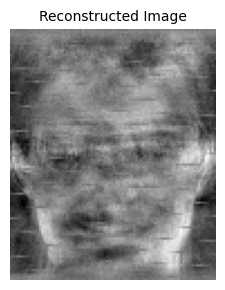

Decoding:  s18


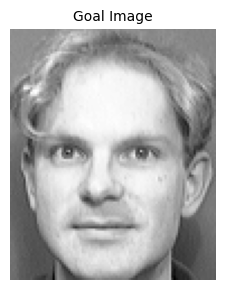

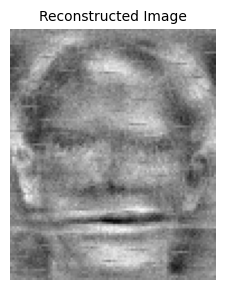

In [13]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
loss_object = SparseCategoricalCrossentropy()

def sarahsinversion(model, img, learning_rate, label, best_loss, best_img, counter):
    # show_img_label(tf.reshape(img[0], (IMG_Y_SIZE, IMG_X_SIZE)), "Starting Image:")
    
    with tf.GradientTape() as tape:
        tape.watch(img)
        prediction = model(img, training=False)
        # print("Label:", label, "Prediction:", prediction.numpy())
        loss = loss_object(tf.convert_to_tensor([label]), prediction)
    
    gradient = tape.gradient(loss, img)
    # print("Current Loss:", loss.numpy())
    
    img = tf.clip_by_value(img - learning_rate * gradient, 0, 255)
    # show_img_label(tf.reshape(img[0], (IMG_Y_SIZE, IMG_X_SIZE)), "Updated Image:")
    
    # Add noise
    noise = np.random.normal(loc=0.01, scale=0.001, size=img.shape)
    img = np.clip(img.numpy() + noise, 0, 255)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    # show_img_label(tf.reshape(img[0], (IMG_Y_SIZE, IMG_X_SIZE)), "Noise:")
    
    return img

black_image_tensor = tf.convert_to_tensor(np.zeros((1,IMG_X_SIZE,IMG_Y_SIZE,1)))

# for name_index in range(len(names)):

# reconstruct first 10 faces

for name_index in range(10):
    # if names[name_index] == "s2":
        print("Decoding: ", names[name_index])
        show_img_label(tf.reshape(XT[name_index], (IMG_Y_SIZE, IMG_X_SIZE)), "Goal Image")
        best_img = black_image_tensor
        best_loss = float('inf')
        for i in range(100):
            best_img = sarahsinversion(model, best_img, 0.1, name_index, best_img, best_loss, i)
        show_img_label(tf.reshape(best_img, (IMG_Y_SIZE, IMG_X_SIZE)), "Reconstructed Image")
    # break


